In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
def preprocess_text(text):
    # Tokenize text
    tokens = bert_tokenizer.tokenize(text)

    # Add special tokens [CLS] and [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Convert tokens to token IDs
    input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

    # Pad or truncate input IDs to a fixed length
    max_length = 12
    padding_length = max_length - len(input_ids)
    input_ids = input_ids + [0] * padding_length  # Padding token ID for BERT

    # Create attention mask
    attention_mask = [1] * len(input_ids)  # 1 for real tokens, 0 for padding tokens

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    attention_mask = torch.tensor(attention_mask).unsqueeze(0)  # Add batch dimension

    return input_ids, attention_mask

In [ ]:
# Function to perform image augmentation
def augment_image(image_path):
    # Define image transformations for augmentation
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ])

    # Open image
    img = Image.open(image_path)

    # Apply augmentation
    augmented_img = augmentation(img)

    # Convert augmented image to array
    img_array = tf.keras.preprocessing.image.img_to_array(augmented_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    return preprocess_input(img_array)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat, vegetables, fruit, and bread.'
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

Processed Text: colorful dishes holding meat vegetables fruit bread


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)

dataArray = np.asarray(dataList) # Converting the list to numpy array

print(dataArray)



# Print preprocessed text
print("Original Text:", text)

# Convert token IDs back to tokens using BERT tokenizer
tokens = bert_tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())
print("Tokens:", tokens)

['colorful dish holding meat vegetable fruit bread']
Original Text: colorful dishes holding meat vegetables fruit and bread.


NameError: name 'input_ids' is not defined

In [ ]:
#if __name__ == "__main__":
# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"
text = dataArray[0]

# Perform image augmentation
augmented_image = augment_image(image_path)
# Append the preprocessed image to the list
preprocessed_images = [preprocess_image(image_path), augmented_image]

# Display preprocessed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(preprocessed_images[0][0]/255.)  # Ensure the correct data type
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_images[1][0]/255.)
axes[1].axis('off')
axes[1].set_title('Augmented Image')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']


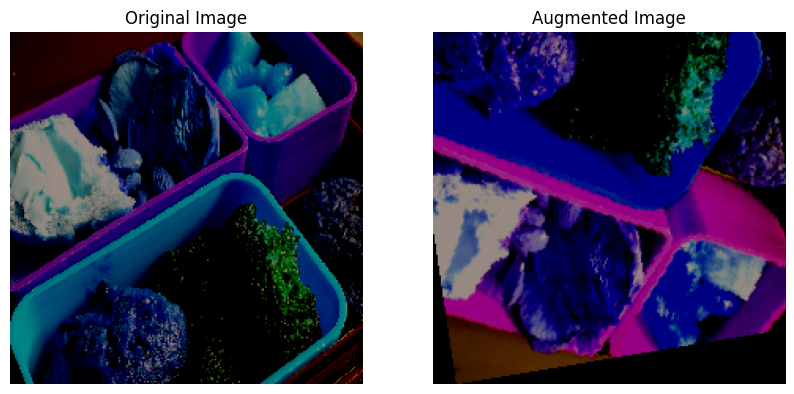

Original Text: colorful dish holding meat vegetable fruit bread
Tokens: ['[CLS]', 'colorful', 'dish', 'holding', 'meat', 'vegetable', 'fruit', 'bread', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array

def preprocess_text(text):
    # Tokenize text
    tokens = bert_tokenizer.tokenize(text)

    # Add special tokens [CLS] and [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Convert tokens to token IDs
    input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

    # Pad or truncate input IDs to a fixed length
    max_length = 12
    padding_length = max_length - len(input_ids)
    input_ids = input_ids + [0] * padding_length  # Padding token ID for BERT

    # Create attention mask
    attention_mask = [1] * len(input_ids)  # 1 for real tokens, 0 for padding tokens

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    attention_mask = torch.tensor(attention_mask).unsqueeze(0)  # Add batch dimension

    return input_ids, attention_mask

def augment_image(image_path):
    # Define image transformations for augmentation
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
    ])

    # Open image
    img = Image.open(image_path)

    # Apply augmentation
    augmented_img = augmentation(img)

    # Convert augmented image to array
    img_array = tf.keras.preprocessing.image.img_to_array(augmented_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)  # Preprocess the image

    return img_array

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat vegetables fruit and bread.'
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)

dataArray = np.asarray(dataList) # Converting the list to numpy array

print(dataArray)

#if __name__ == "__main__":
# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"
text = dataArray[0]

# Perform image augmentation
augmented_image = augment_image(image_path)
# Append the preprocessed image to the list
preprocessed_images = [preprocess_image(image_path), augmented_image]

# Display preprocessed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(preprocessed_images[0][0]/255.)  # Ensure the correct data type
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_images[1][0]/255.)
axes[1].axis('off')
axes[1].set_title('Augmented Image')
plt.show()

# Print preprocessed text
print("Original Text:", text)

# Get input_ids and attention_mask
input_ids, attention_mask = preprocess_text(text)

# Convert token IDs back to tokens using BERT tokenizer
tokens = bert_tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())
print("Tokens:", tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']
List size is:  2


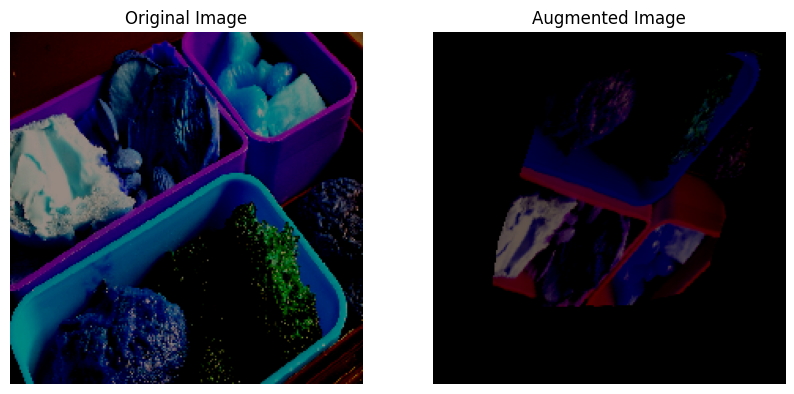

Original Text: colorful dish holding meat vegetable fruit bread
Tokens: ['[CLS]', 'colorful', 'dish', 'holding', 'meat', 'vegetable', 'fruit', 'bread', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array

def preprocess_text(text):
    # Tokenize text
    tokens = bert_tokenizer.tokenize(text)

    # Add special tokens [CLS] and [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Convert tokens to token IDs
    input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

    # Pad or truncate input IDs to a fixed length
    max_length = 12
    padding_length = max_length - len(input_ids)
    input_ids = input_ids + [0] * padding_length  # Padding token ID for BERT

    # Create attention mask
    attention_mask = [1] * len(input_ids)  # 1 for real tokens, 0 for padding tokens

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    attention_mask = torch.tensor(attention_mask).unsqueeze(0)  # Add batch dimension

    return input_ids, attention_mask

def augment_image(image_path):
    # Define image transformations for augmentation
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
    ])

    # Open image
    img = Image.open(image_path)

    # Apply augmentation
    augmented_img = augmentation(img)

    # Convert augmented image to array
    img_array = tf.keras.preprocessing.image.img_to_array(augmented_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)  # Preprocess the image

    return img_array

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat vegetables fruit and bread.'
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)

dataArray = np.asarray(dataList) # Converting the list to numpy array

print(dataArray)

#if __name__ == "__main__":
# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"
text = dataArray[0]

# Perform image augmentation
augmented_image = augment_image(image_path)
# Append the preprocessed image to the list
preprocessed_images = [preprocess_image(image_path), augmented_image]
print('List size is: ',len(preprocessed_images))

# Display preprocessed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(preprocessed_images[0][0]/255.)  # Ensure the correct data type
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_images[1][0]/255.)
axes[1].axis('off')
axes[1].set_title('Augmented Image')
plt.show()

# Print preprocessed text
print("Original Text:", text)

# Get input_ids and attention_mask
input_ids, attention_mask = preprocess_text(text)

# Convert token IDs back to tokens using BERT tokenizer
tokens = bert_tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())
print("Tokens:", tokens)

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array

def augment_image(image_path):
    # Define image transformations for augmentation
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
    ])

    # Open image
    img = Image.open(image_path)

    # Apply augmentation
    augmented_img = augmentation(img)

    # Convert augmented image to array
    img_array = tf.keras.preprocessing.image.img_to_array(augmented_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)  # Preprocess the image

    return img_array

def normalize_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def grayscale_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((224, 224))  # Resize to (224, 224)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def equalize_histogram_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Convert image to RGB
    img = img.resize((224, 224))  # Resize to (224, 224)
    img_array = np.array(img)
    img_array = tf.image.rgb_to_yuv(img_array)  # Convert to YUV color space
    img_array = tf.image.equalize_histogram(img_array[:, :, 0])  # Apply histogram equalization to Y channel
    img_array = tf.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = tf.concat([img_array, img_array, img_array], axis=-1)  # Stack equalized Y channel with UV channels
    img_array = np.array(img_array)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat vegetables fruit and bread.'
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)

dataArray = np.asarray(dataList) # Converting the list to numpy array

print(dataArray)

# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"

# Perform image augmentation
augmented_image = augment_image(image_path)
# Append the preprocessed image to the list
preprocessed_images = [
    preprocess_image(image_path),
    augmented_image,
    normalize_image(image_path),
    grayscale_image(image_path),
    equalize_histogram_image(image_path)
]

# Display preprocessed images
fig, axes = plt.subplots(1, len(preprocessed_images), figsize=(20, 5))
titles = ['Original Image', 'Augmented Image', 'Normalized Image', 'Grayscale Image', 'Histogram Equalized Image']
for ax, image, title in zip(axes, preprocessed_images, titles):
    ax.imshow(image.squeeze())
    ax.axis('off')
    ax.set_title(title)
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']


AttributeError: shape

In [10]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array

def augment_image(image_path):
    # Define image transformations for augmentation
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
    ])

    # Open image
    img = Image.open(image_path)

    # Apply augmentation
    augmented_img = augmentation(img)

    # Convert augmented image to array
    img_array = tf.keras.preprocessing.image.img_to_array(augmented_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)  # Preprocess the image

    return img_array

def normalize_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def grayscale_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((224, 224))  # Resize to (224, 224)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat, vegetables, fruit, and bread.'
print("Original Text:", text)
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)

dataArray = np.asarray(dataList) # Converting the list to numpy array

print(dataArray)

# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"

# Perform image augmentation
augmented_image = augment_image(image_path)
# Append the preprocessed image to the list
preprocessed_images = [
    preprocess_image(image_path),
    augmented_image,
    normalize_image(image_path),
    grayscale_image(image_path),
    #equalize_histogram_image(image_path)
]

# Display preprocessed images
fig, axes = plt.subplots(1, len(preprocessed_images), figsize=(20, 5))
titles = ['Original Image', 'Augmented Image', 'Normalized Image', 'Grayscale Image']
for ax, image, title in zip(axes, preprocessed_images, titles):
    ax.imshow(np.squeeze(image))  # Ensure to squeeze the image data to remove extra dimensions
    ax.axis('off')
    ax.set_title(title)
plt.show()


Original Text: colorful dishes holding meat, vegetables, fruit, and bread.
Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


AttributeError: shape

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Text: colorful dishes holding meat, vegetables, fruit, and bread.
Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']


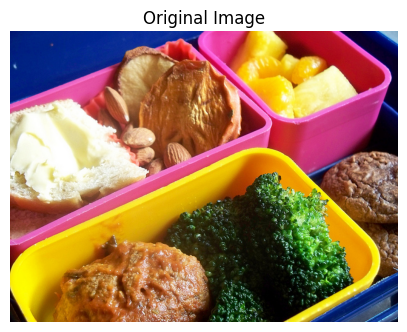

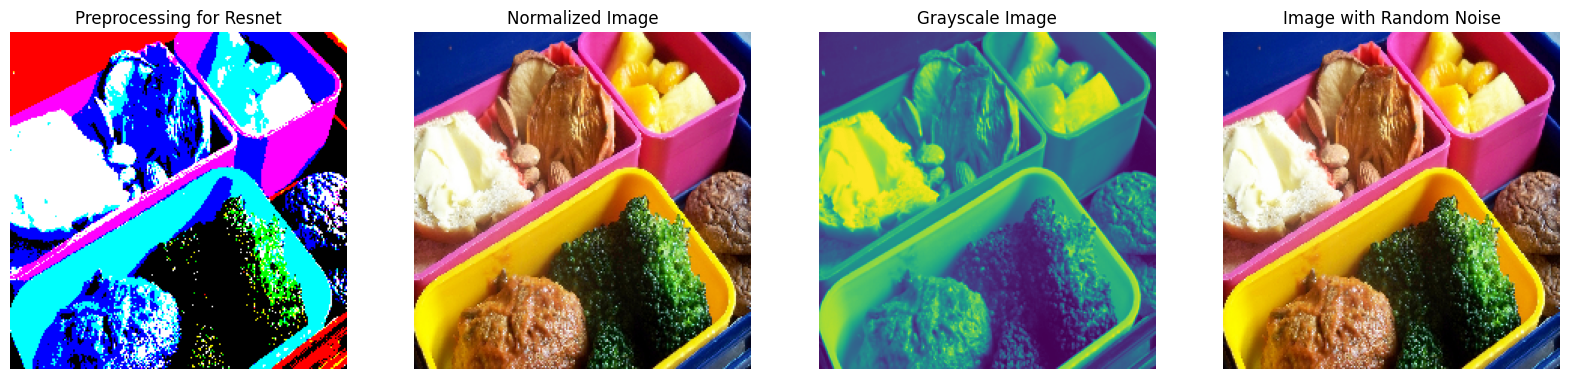

In [18]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array


def normalize_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def grayscale_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((224, 224))  # Resize to (224, 224)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def add_random_noise(image_path, noise_factor=0.1):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    noise = np.random.normal(loc=0.0, scale=1.0, size=img_array.shape)
    noisy_img = img_array + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0., 255.) / 255.
    return noisy_img

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat, vegetables, fruit, and bread.'
print("Original Text:", text)
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)
dataArray = np.asarray(dataList) # Converting the list to numpy array
print(dataArray)
# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"

# Load and display the original image
original_image = Image.open(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()


# Append the preprocessed image to the list
preprocessed_images = [
    preprocess_image(image_path),
    normalize_image(image_path),
    grayscale_image(image_path),
    add_random_noise(image_path)
]

# Display preprocessed images
fig, axes = plt.subplots(1, len(preprocessed_images), figsize=(20, 5))
titles = ['Preprocessing for Resnet', 'Normalized Image', 'Grayscale Image', 'Image with Random Noise']
for ax, image, title in zip(axes, preprocessed_images, titles):
    ax.imshow(np.squeeze(image))  # Ensure to squeeze the image data to remove extra dimensions
    ax.axis('off')
    ax.set_title(title)
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Text: colorful dishes holding meat, vegetables, fruit, and bread.
Processed Text: colorful dishes holding meat vegetables fruit bread
['colorful dish holding meat vegetable fruit bread']


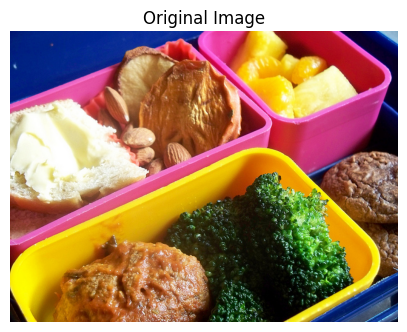

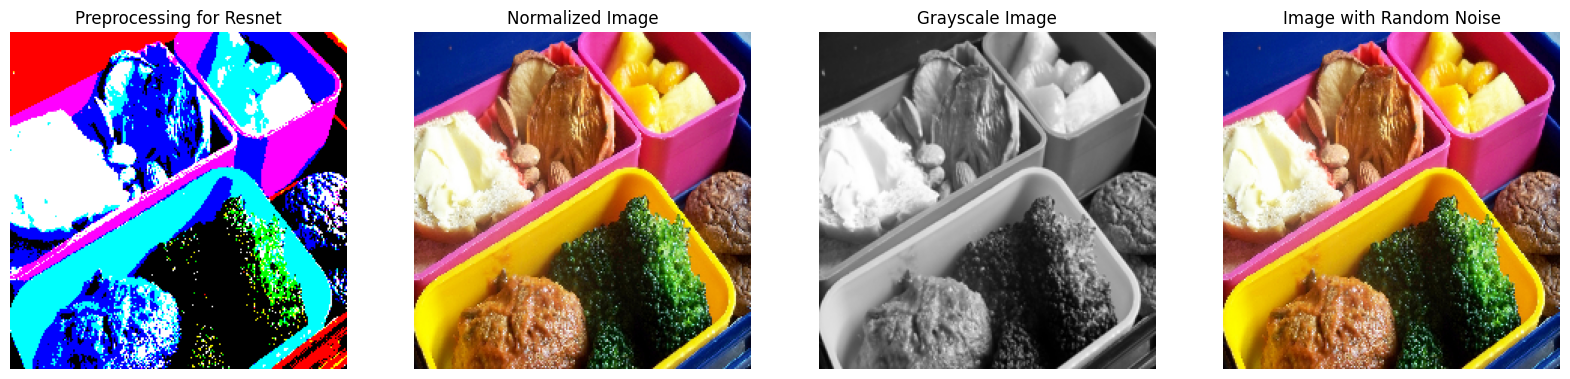

In [19]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import re
import nltk

# Define the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)
    return img_array


def normalize_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def grayscale_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((224, 224))  # Resize to (224, 224)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.concatenate([img_array, img_array, img_array], axis=-1)  # Convert to 3-channel grayscale
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def add_random_noise(image_path, noise_factor=0.1):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    noise = np.random.normal(loc=0.0, scale=1.0, size=img_array.shape)
    noisy_img = img_array + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0., 255.) / 255.
    return noisy_img

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

text = 'colorful dishes holding meat, vegetables, fruit, and bread.'
print("Original Text:", text)
processed_text = np.vectorize(remove_pattern)(text, "@[\w]*") #removing special characters(except #)

# Convert the numpy array to a string
processed_text_str = ' '.join(processed_text.flatten().tolist())

# Remove unwanted text patterns
processed_text_str = re.sub("@[\w]*", "", processed_text_str)  # removing special characters (except #)
processed_text_str = re.sub("[^a-zA-Z#]", " ", processed_text_str)  # removing everything except alphabets and #
processed_text_str = re.sub(r'http\S+', " ", processed_text_str)  # removing links
processed_text_str = ' '.join([w for w in processed_text_str.split() if len(w) > 3])  # removing words of shorter length

# Print the processed text
print("Processed Text:", processed_text_str)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

dataList = []
lemma = WordNetLemmatizer()

# Example input strings
input_string = processed_text_str
data = input_string

#for data in input_strings:
data = data.lower()
data = nltk.word_tokenize(data)
#removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
stop_words = set(stopwords.words('english'))
data = [w for w in data if not w in stop_words]
data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
data = " ".join(data)
dataList.append(data)
dataArray = np.asarray(dataList) # Converting the list to numpy array
print(dataArray)
# Example usage
image_path = "/content/COCO_train2014_000000000009.jpg"

# Load and display the original image
original_image = Image.open(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Append the preprocessed image to the list
preprocessed_images = [
    preprocess_image(image_path),
    normalize_image(image_path),
    grayscale_image(image_path),
    add_random_noise(image_path)
]

# Display preprocessed images
fig, axes = plt.subplots(1, len(preprocessed_images), figsize=(20, 5))
titles = ['Preprocessing for Resnet', 'Normalized Image', 'Grayscale Image', 'Image with Random Noise']
for ax, image, title in zip(axes, preprocessed_images, titles):
    ax.imshow(np.squeeze(image))  # Ensure to squeeze the image data to remove extra dimensions
    ax.axis('off')
    ax.set_title(title)
plt.show()
